In [2]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy

from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import xgboost as xgb
import os

In [3]:
#open the fits file - my table
with fits.open("GR_theBigtable.fits") as data:
    table = data[1].data
    df = pd.DataFrame(table)
    
df['objtype'] = df['objtype'].str.strip()

df.loc[((df.z_spec > 2.0)*(df.objtype=="QSO"), 'objtype')] = 'QSOhighZ'

KeyboardInterrupt: 

In [4]:
#create empty dataframe
df = pd.DataFrame()

#open the fits file - Giorgos table
for filename in os.listdir('./giorgio_table'):
    with fits.open("./giorgio_table/"+filename) as data:
        dfi= pd.DataFrame()
        table = data[1].data
        for col in table.columns:
            if len(table[col.name].shape) > 1:
                dfi[col.name] = table[col.name][:,0]
            else:
                dfi[col.name] = table[col.name]
        
        df = df.append(dfi)

#remove blank spaces from df.objtype
df['objtype'] = df['objtype'].str.strip()

In [5]:
#optional - remove the rows with ' ' objtype
df = df[df['objtype'] != '']
df.objtype.value_counts()

Star        5960751
Galaxy       150581
QSOlowZ       16274
other          2172
QSOhighZ       1903
Name: objtype, dtype: int64

In [14]:
#CONTROL WHAT THE ALGORITHM DOES
name="MY_random_colors_allmags_nans_notnormalized_fewclass"

#renormalize to the 90% confidence interval. If false, colors are not normalized
renormalize = False


#assign_invalid_value
assign_invalid_value = np.nan

#group indeces
label2num_map = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 2, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 2,
                 'BLLac': 2,
                 'EmLines': 2,
                 'Uncertain': 2, 
                 'QSO': 3,
                 'QSOlowZ': 3,
                  'QSOhighZ': 4,
                 }

"""label2num_map = {'Galaxy': 0,
                 'Extended?': 2, 
                 'Type2': 3,#2, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 2,#2,
                 'BLLac': 4,#2,
                 'EmLines': 5,#2,
                 'Uncertain': 6,#2, 
                 'QSO': 7,
                 'QSOlowZ': 7,
                  'QSOhighZ': 8,
                 }"""

idlabels=["galaxies","stars","other","lowZ QSO","highZ QSO"]
#idlabels=["galaxies","stars","lowZ QSO","highZ QSO"]
#idlabels=["galaxies","stars","Extended/other","type2","BLLAC","EmLines","Uncertain","lowZ QSO","highZ QSO"]

magnitudes_random_shuffle=False

add_the_following_mags=[]#["phot_bp_mean_mag" ,"gPSFMag","phot_g_mean_mag", "rPSFMag", "phot_rp_mean_mag",
       #       "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

#from colors
remove_the_following_mags=[]
#add_the_following_mags=["phot_bp_mean_mag"]

stratify=True



magnitudes = ["phot_bp_mean_mag" ,"gPSFMag","phot_g_mean_mag", "rPSFMag", "phot_rp_mean_mag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

In [17]:
def prepare_dataset(df, magnitudes_for_colors,magnitudes_just_magnitudes, label2num_map, assign_invalid_value=np.nan, renormalize=False):
    #pusti instrumente skupaj!

    labels = np.asarray([label2num_map[l] for l in df['objtype']])

    #set nan values to assign_invalid_value
    for mag in magnitudes_just_magnitudes:
        #apply mask with df loc
        df.loc[df[mag].isna(),mag]=assign_invalid_value
        df.loc[df[mag] < 0,mag]=assign_invalid_value
    
    for mag in magnitudes_for_colors:
        #apply mask with df loc
        df.loc[df[mag].isna(),mag]=assign_invalid_value
        df.loc[df[mag] < 0,mag]=assign_invalid_value

    features = pd.DataFrame()

    #define the confidence interval for rescaling
    alpha=0.99

    colors=list()
    for i in range(0, len(magnitudes_for_colors)-1):
        colors.append(magnitudes_for_colors[i]+"-"+magnitudes_for_colors[i+1])
        features[colors[i]]=df[magnitudes_for_colors[i]]-df[magnitudes_for_colors[i+1]]
        
    for i in range(0, len(magnitudes_just_magnitudes)):
        colors.append(magnitudes_just_magnitudes[i])
        features[magnitudes_just_magnitudes[i]]=df[magnitudes_just_magnitudes[i]]

    for i in range(0, len(colors)):
        #mask the nan values
        mask_justnan=pd.notna(features[colors[i]])
        #print("nan color {} {:.1f} %".format(np.sum(np.invert(mask_justnan)),np.sum(np.invert(mask_justnan))/len(mask_justnan)*100))

        #identify the (1-alpha)/2 and 1-(1-alpha)/2 quantiles
        q1=features[colors[i]][mask_justnan].quantile((1-alpha)/2)
        q2=features[colors[i]][mask_justnan].quantile(1-(1-alpha)/2)
        median=features[colors[i]][mask_justnan].median()

        #rescale the colors so that the quantiles are between -1 and 1
        if renormalize:
            features[colors[i]]=2*(features[colors[i]]-median)/(q2-q1)

        #print("quantiles for color {}: {} {}".format(colors[i], q1, q2))
        if i>len(colors)-1:continue

        #set the masked out values to 999 with .loc
        features.loc[np.invert(mask_justnan), colors[i]]=assign_invalid_value
    return features, labels


In [133]:
def run_the_stratified_model(param,features,labels,label2num_map_i,n_splits=5,steps=200,returnmodel=False):
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True)
    #use cv StratifiedKfold to loop thorugh the folds
    ID_qsos=label2num_map_i["QSOhighZ"]
    recalls=[]
    precisions=[]
    losses=[]
    print("returnmodel: {}".format(returnmodel))
    for train_index, test_index in cv.split(features, labels):
        #model = xgb.train(param, D_train, steps, watchlist, evals_result=evals_result,early_stopping_rounds=10,verbose_eval=False)
        model=xgb.XGBClassifier(**param,early_stopping_rounds=10)
        print("--")
        model.fit(features.iloc[train_index], labels[train_index],eval_set=[(features.iloc[test_index], labels[test_index])],verbose=False)
        #train_losses.append(evals_result['Train']['mlogloss'])
        #test_losses.append(evals_result['Test']['mlogloss'])

        ypred = model.predict(features.iloc[test_index])
        precisions.append(np.sum((ypred==ID_qsos)*(labels[test_index]==ID_qsos))/np.sum(ypred==ID_qsos))
        recalls.append(np.sum((ypred==ID_qsos)*(labels[test_index]==ID_qsos))/np.sum(labels[test_index]==ID_qsos))
        #losses.append(metrics.log_loss(labels[test_index], ypred))
        print("precision: {:.2f} recall: {:.2f}".format(precisions[-1],recalls[-1]))
        print(np.sum(labels[test_index]==ID_qsos))
        print(ID_qsos)
        print(np.unique(ypred))
        print(np.unique(labels[test_index]))
        print(np.unique(labels[train_index]))
        #print number of features (feature columns)
        print("number of features: {}".format(len(features.columns)))
        
    if returnmodel:  return np.mean(precisions), np.mean(recalls), np.std(precisions), np.std(recalls), np.min(precisions), np.max(precisions),  np.min(recalls), np.max(recalls),model
    else: return np.mean(precisions), np.mean(recalls), np.std(precisions), np.std(recalls), np.min(precisions), np.max(precisions),  np.min(recalls), np.max(recalls)




In [120]:

param = {
    'max_depth': 10,  
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': len(idlabels),
    'subsamble':0.01
   #'verbose':2
    }
steps = 2  

label2num_map1 = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 2, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 2,
                 'BLLac': 2,
                 'EmLines': 2,
                 'Uncertain': 2, 
                 'QSO': 3,
                 'QSOlowZ': 3,
                  'QSOhighZ': 4,
                 }

label2num_map2 = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 0, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 0,
                 'BLLac': 0,
                 'EmLines': 0,
                 'Uncertain': 0, 
                 'QSO': 2,
                 'QSOlowZ': 2,
                  'QSOhighZ': 3,
                 }

label2num_map3 = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 0, 
                 'Star': 0, 
                 'star': 0, 
                 'other': 0,
                 'BLLac': 0,
                 'EmLines': 0,
                 'Uncertain': 0, 
                 'QSO': 1,
                 'QSOlowZ': 1,
                  'QSOhighZ': 2,
                 }

label2num_map4 = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 0, 
                 'Star': 0, 
                 'star': 0, 
                 'other': 0,
                 'BLLac': 0,
                 'EmLines': 0,
                 'Uncertain': 0, 
                 'QSO': 0,
                 'QSOlowZ': 0,
                  'QSOhighZ': 1,
                 }

mean_precision=[]
mean_recall=[]
std_precision=[]
std_recall=[]
min_precision=[]
max_precision=[]
min_recall=[]
max_recalll=[]


for i,label2num_i in enumerate([label2num_map1,label2num_map2,label2num_map3,label2num_map4]):
    features,labels=prepare_dataset(df, magnitudes, add_the_following_mags, label2num_i, assign_invalid_value, renormalize)   
    mpr,mrc,spr,src,minp,maxp,minr,maxr=run_the_stratified_model(param,features,labels,label2num_i,n_splits=5,steps=200)
    mean_precision.append(mpr)
    mean_recall.append(mrc)
    std_precision.append(spr)
    std_recall.append(src)
    min_precision.append(minp)
    max_precision.append(maxp)
    min_recall.append(minr)
    max_recalll.append(maxr)

returnmodel: False
--


KeyboardInterrupt: 

In [80]:
print()

[0.8370607028753994, nan, nan, 0.8143322475570033]


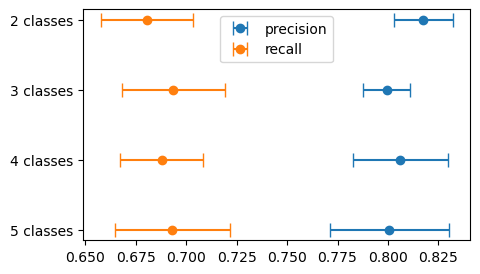

In [99]:
#print errorbars for the different models
xlabels=["5 classes","4 classes","3 classes","2 classes"]
plt.figure(figsize=(5,3))
plt.errorbar(mean_precision,xlabels,xerr=std_precision,fmt='o',label="precision",capsize=5)
plt.errorbar(mean_recall,xlabels,xerr=std_recall,fmt='o',label="recall",capsize=5)
plt.legend()
#plt.xlabel("number of classes")
plt.savefig("./figures/PR_classnumber.png",bbox_inches='tight')
plt.savefig("./figures/PR_classnumber.pdf",bbox_inches='tight',format='pdf')

In [134]:
param = {
    'max_depth': 10,  
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': len(idlabels),
    'verbose':2
    }
steps = 2  

label2num_map = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 2, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 2,
                 'BLLac': 2,
                 'EmLines': 2,
                 'Uncertain': 2, 
                 'QSO': 3,
                 'QSOlowZ': 3,
                  'QSOhighZ': 4,
                 }

magnitudes1 = ["phot_bp_mean_mag" ,"phot_g_mean_mag", "phot_rp_mean_mag","gPSFMag","rPSFMag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

magnitudes2 = ["phot_g_mean_mag", "phot_rp_mean_mag","gPSFMag","rPSFMag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

magnitudes3=["phot_bp_mean_mag" ,"phot_g_mean_mag","gPSFMag","rPSFMag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

magnitudes4=["phot_bp_mean_mag" ,"phot_g_mean_mag", "phot_rp_mean_mag","gPSFMag","rPSFMag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro"]

magnitudes5=["phot_bp_mean_mag" ,"phot_g_mean_mag", "phot_rp_mean_mag","gPSFMag","rPSFMag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro"]

mean_precision2=[]
mean_recall2=[]
std_precision2=[]
std_recall2=[]
min_precision2=[]
max_precision2=[]
min_recall2=[]
max_recalll2=[]

xlabels_magnitudes=["all","no_bp","no_rp","no_w4","no_w"]

for i,magnitudes_i in enumerate([magnitudes1,magnitudes2,magnitudes3,magnitudes4,magnitudes5]):
    features,labels=prepare_dataset(df, magnitudes_i, add_the_following_mags, label2num_map, assign_invalid_value, renormalize)   
    mpr,mrc,spr,src,minp,maxp,minr,maxr,model=run_the_stratified_model(param,features,labels,label2num_map,n_splits=5,steps=200,returnmodel=True)
    mean_precision2.append(mpr)
    mean_recall2.append(mrc)
    std_precision2.append(spr)
    std_recall2.append(src)
    min_precision2.append(minp)
    max_precision2.append(maxp)
    min_recall2.append(minr)
    max_recalll2.append(maxr)
    plt.barh(features.columns, model.feature_importances_,orientation="horizontal")
    plt.savefig("figures/influence_{}.png".format(xlabels_magnitudes[i]),dpi=300)
    plt.savefig("figures/influence_{}.pdf".format(xlabels_magnitudes[i]),dpi=300,format='pdf')

returnmodel: True
--
[16:44:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


precision: 0.84 recall: 0.74
380
4
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
number of features: 11
--
[16:48:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

In [ ]:
#CONTROL WHAT THE ALGORITHM DOES
name="MY_random_colors_allmags_nans_notnormalized_fewclass"

#renormalize to the 90% confidence interval. If false, colors are not normalized
renormalize = False


#assign_invalid_value
assign_invalid_value = np.nan

#group indeces
label2num_map = {'Galaxy': 0,
                 'Extended?': 0, 
                 'Type2': 2, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 2,
                 'BLLac': 2,
                 'EmLines': 2,
                 'Uncertain': 2, 
                 'QSO': 3,
                 'QSOlowZ': 3,
                  'QSOhighZ': 4,
                 }

"""label2num_map = {'Galaxy': 0,
                 'Extended?': 2, 
                 'Type2': 3,#2, 
                 'Star': 1, 
                 'star': 1, 
                 'other': 2,#2,
                 'BLLac': 4,#2,
                 'EmLines': 5,#2,
                 'Uncertain': 6,#2, 
                 'QSO': 7,
                 'QSOlowZ': 7,
                  'QSOhighZ': 8,
                 }"""

idlabels=["galaxies","stars","other","lowZ QSO","highZ QSO"]
#idlabels=["galaxies","stars","lowZ QSO","highZ QSO"]
#idlabels=["galaxies","stars","Extended/other","type2","BLLAC","EmLines","Uncertain","lowZ QSO","highZ QSO"]

magnitudes_random_shuffle=False

add_the_following_mags=[]#["phot_bp_mean_mag" ,"gPSFMag","phot_g_mean_mag", "rPSFMag", "phot_rp_mean_mag",
       #       "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

#from colors
remove_the_following_mags_1=[]
add_the_following_mags_2=["w4mpro"]
add_the_following_mags_3=["phot_bp_mean_mag" ,"gPSFMag","phot_g_mean_mag", "rPSFMag", "phot_rp_mean_mag",
             "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

stratify=True



magnitudes = ["phot_bp_mean_mag" ,"gPSFMag","phot_g_mean_mag", "rPSFMag", "phot_rp_mean_mag",
              "iPSFMag", "zPSFMag", "yPSFMag","w1mpro", "w2mpro", "w3mpro", "w4mpro"]

xlabels_additionalmags=["none","w4mpro","all"]

mean_precision3=[]
mean_recall3=[]
std_precision3=[]
std_recall3=[]
min_precision3=[]
max_precision3=[]
min_recall3=[]
max_recalll3=[]

for i,magnitudes_i in enumerate([magnitudes1,magnitudes2,magnitudes3,magnitudes4,magnitudes5]):
    features,labels=prepare_dataset(df, magnitudes_i, add_the_following_mags, label2num_map, assign_invalid_value, renormalize)   
    mpr,mrc,spr,src,minp,maxp,minr,maxr=run_the_stratified_model(param,features,labels,label2num_map,n_splits=5,steps=200,returnmodel=False)
    mean_precision3.append(mpr)
    mean_recall3.append(mrc)
    std_precision3.append(spr)
    std_recall3.append(src)
    min_precision3.append(minp)
    max_precision3.append(maxp)
    min_recall3.append(minr)
    max_recalll3.append(maxr)


In [132]:
print(mean_recall2)

[]


In [104]:
features

,phot_bp_mean_mag-phot_g_mean_mag,phot_g_mean_mag-phot_rp_mean_mag,phot_rp_mean_mag-gPSFMag,gPSFMag-rPSFMag,rPSFMag-iPSFMag,iPSFMag-zPSFMag,zPSFMag-yPSFMag,yPSFMag-w1mpro,w1mpro-w2mpro,w2mpro-w3mpro,w3mpro-w4mpro
2,0.589800,0.706200,-1.441399,0.724400,0.361000,0.117100,0.110201,1.863299,-0.031000,2.903000,3.354000
5,0.546099,0.667101,-1.292500,0.625200,0.277399,0.123600,0.104601,NaN,NaN,NaN,NaN
18,1.283400,1.019600,-2.592999,1.347799,0.904400,0.475700,0.187399,2.173700,0.410001,3.311000,3.160999
21,0.461899,0.535801,-0.969801,0.446600,0.238001,0.095600,0.038700,1.695799,0.005001,4.308999,3.090000
22,0.563799,0.693001,-1.477001,0.835001,0.280800,0.141399,0.095400,1.683001,0.148001,3.389999,3.861000
...,...,...,...,...,...,...,...,...,...,...,...
810108,0.695299,0.676001,-1.566401,0.863201,0.401499,0.190201,0.152599,NaN,NaN,NaN,NaN
810109,0.715500,1.007101,-2.220301,1.115499,0.705601,0.306200,0.186100,2.045500,-0.077000,4.179000,3.165999
810110,0.228300,1.487000,-1.966501,0.910601,0.578300,0.379499,0.130899,3.071301,0.407001,3.370000,3.062000
810111,0.871901,1.092100,-2.895300,1.393900,1.012600,0.596498,0.249901,NaN,NaN,NaN,NaN


In [64]:
print(mean_precision)

[]


In [18]:
features,labels=prepare_dataset(df, magnitudes, add_the_following_mags, label2num_map, assign_invalid_value, renormalize)

In [10]:
if stratify: stratify_input=labels
else: stratify_input=None

Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2, random_state=1, stratify=stratify_input)

MACHINE LEARNING PART

In [11]:
import matplotlib.colors as clrs

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,fontsize=30,
                          logcolor=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,6))
    print(cm)
    if logcolor:
        min=1
        plt.imshow(cm, interpolation='nearest', cmap=cmap,norm=clrs.LogNorm(vmin=min, vmax=np.max(cm)))
    else: 
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="black", fontsize = fontsize)
            plt.text(j+0.01*fontsize, i+0.015*fontsize, "R: {:.2f}%".format(cm[i, j]/np.sum(cm[i, :])*100),
                horizontalalignment="center", verticalalignment="center",
                color="black", fontsize = fontsize)
            plt.text(j+0.01*fontsize, i-0.015*fontsize, "P: {:.2f}%".format(cm[i, j]/np.sum(cm[:, j])*100),
                horizontalalignment="center", verticalalignment="center",
                color="black", fontsize = fontsize)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
param = {
    'max_depth': 10,  
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': len(idlabels),
    'verbose':2
    }
steps = 2  # The number of training iterations

In [22]:
Dmatrix = xgb.DMatrix(features, label=labels)

In [49]:
cv=StratifiedKFold(n_splits=2, shuffle=True)
#use cv StratifiedKfold to loop thorugh the folds
train_losses=[]
test_losses=[]

ID_qsos=label2num_map["QSOhighZ"]
recalls=[]
precisions=[]
losses=[]
for train_index, test_index in cv.split(features, labels):
    D_train = xgb.DMatrix(features.iloc[train_index], label=labels[train_index])
    D_test  = xgb.DMatrix(features.iloc[test_index] , label=labels[test_index])
    watchlist = [(D_train, 'Train'), (D_test,'Test')]
    evals_result = {}
    #model = xgb.train(param, D_train, steps, watchlist, evals_result=evals_result,early_stopping_rounds=10,verbose_eval=False)
    model=xgb.XGBClassifier(**param,steps=steps,early_stopping_rounds=10)
    print("--")
    model.fit(features.iloc[train_index], labels[train_index],eval_set=[(features.iloc[test_index], labels[test_index])],verbose=False)
    #train_losses.append(evals_result['Train']['mlogloss'])
    #test_losses.append(evals_result['Test']['mlogloss'])

    ypred = model.predict(features.iloc[test_index])
    precisions.append(np.sum((ypred==ID_qsos)*(labels[test_index]==ID_qsos))/np.sum(ypred==ID_qsos))
    recalls.append(np.sum((ypred==ID_qsos)*(labels[test_index]==ID_qsos))/np.sum(labels[test_index]==ID_qsos))
    #losses.append(metrics.log_loss(labels[test_index], ypred))




--
[00:53:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "steps", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




ValueError: y_true and y_pred contain different number of classes 5, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4]

In [50]:
ypred = model.predict(features.iloc[test_index])

In [52]:
print(np.unique(ypred))

[0 1 2 3 4]


In [61]:
#metrics.log_loss(labels[test_index],ypred,labels=np.(labels[test_index]))

AttributeError: module 'numpy' has no attribute 'flatten'

In [56]:
np.unique(labels[test_index])
#, ypred

array([0, 1, 2, 3, 4])

In [57]:
np.unique(ypred)

array([0, 1, 2, 3, 4], dtype=int32)

In [ ]:
for i,j 

In [23]:
test_losses

[[0.9488815346428882,
  0.6470302525333886,
  0.45976066728748755,
  0.33399437717050606,
  0.24637708577145212,
  0.18407546896720273,
  0.13926877217240008,
  0.10678898952164803,
  0.08313040532588316,
  0.06582552426409667,
  0.05314610905001251,
  0.04382668801555067,
  0.03696387904967082,
  0.03191436375635496,
  0.02818630052629408,
  0.02541793542113956,
  0.02337023617387293,
  0.02184475718035222,
  0.02071525192000776,
  0.01987484681160948,
  0.01924233459679717,
  0.01877210767562528,
  0.01840274836144548,
  0.01812408764669558,
  0.01791815412867708,
  0.01776092256102905,
  0.01763849760732662,
  0.01754512068501816,
  0.01746933772021882,
  0.01741804593249552,
  0.01736629430898478,
  0.01732989101112875,
  0.01730638622115113,
  0.01728005335966824,
  0.01726107869136376,
  0.01724787579356407,
  0.01724302349950703,
  0.01723463720366489,
  0.01723156934629253,
  0.01722782310284197,
  0.01722008883966677,
  0.01722842039310258,
  0.01723340162504248,
  0.017232174

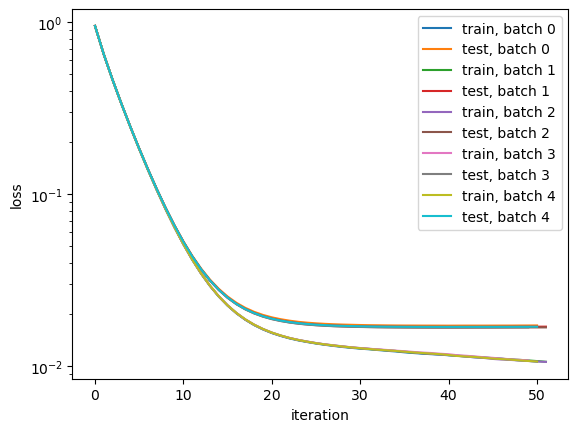

In [30]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label="train, batch {}".format(i))
    plt.plot(test_losses[i], label="test, batch {}".format(i))
    plt.legend()
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.savefig("./figures/losses.png")


In [22]:
test_mean=np.mean(np.asarray(test_losses), axis=0)
test_std=np.std(np.asarray(test_losses), axis=0)
train_mean=np.mean(np.asarray(train_losses), axis=0)
train_std=np.std(np.asarray(train_losses), axis=0)



/Users/gregorrih/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/Users/gregorrih/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [ ]:
plt.plot(train_mean, label="train")
plt.plot(test_mean, label="test")

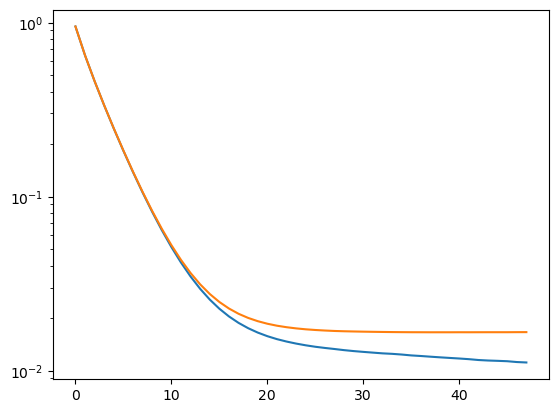

In [53]:
plt.plot(evals_result['Train']['mlogloss'])
plt.plot( evals_result['Test']['mlogloss'])
plt.yscale('log')

In [28]:
DT_basic_regressor = xgb.XGBClassifier(cv= KFold(n_splits=5, shuffle=True))
DT_basic_regressor.fit(features,labels)

[18:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




KeyboardInterrupt: 

In [24]:

#watchlist = [(D_train, 'Train'), (D_test,'Test')]
evals_result = {}
model = xgb.train(param, Dmatrix, 10, evals_result=evals_result)

[18:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




KeyboardInterrupt: 

In [20]:
#from xgboost import cv

params = {"objective":"binary:logistic"}#,'colsample_bytree': 0.3,'learning_rate': 0.1,
           #     'max_depth': 5, 'alpha': 10}

xgb_cv = xgb.cv(dtrain=Dmatrix, params=params)#, nfold=3)#,
                   # num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

XGBoostError: [18:24:30] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:138: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013ca1f705 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x000000013cb65624 xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 820
  [bt] (2) 3   libxgboost.dylib                    0x000000013caf36b5 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 581
  [bt] (3) 4   libxgboost.dylib                    0x000000013ca2354a XGBoosterUpdateOneIter + 138
  [bt] (4) 5   libffi.7.dylib                      0x000000010dc4dead ffi_call_unix64 + 85
  [bt] (5) 6   ???                                 0x000000030ad84910 0x0 + 13066848528



In [ ]:
D_train = xgb.DMatrix(features, label=labels)
D_test  = xgb.DMatrix(features_test , label=nlabels_test)


watchlist = [(D_train, 'Train'), (D_test,'Test')]
evals_result = {}
model = xgb.train(param, D_train, steps, watchlist, evals_result=evals_result)

In [142]:
#create a decision tree regressor - manual calculation of the accuracy

#STRATIFY!!
#def hqso(y): return y==4

DT_basic_regressor = DecisionTreeClassifier()
DT_basic_regressor.fit(Xtrain, ytrain)
ypred = DT_basic_regressor.predict(Xtest)

#print("Accuracy:", metrics.accuracy_score(ytest, ypred))
#print("Precision:", metrics.precision_score(hqso(ytest), hqso(ypred), average="binary"))
#print("Recall:", metrics.recall_score(hqso(ytest), hqso(ypred), average="binary"))
#compute manually to check



Confusion matrix, without normalization
[[  25688    3411     429     582       6]
 [   4012 1197577      16     331     156]
 [    361      24      24      23       2]
 [    517     401      16    1769     138]
 [      9     156       5     136     489]]


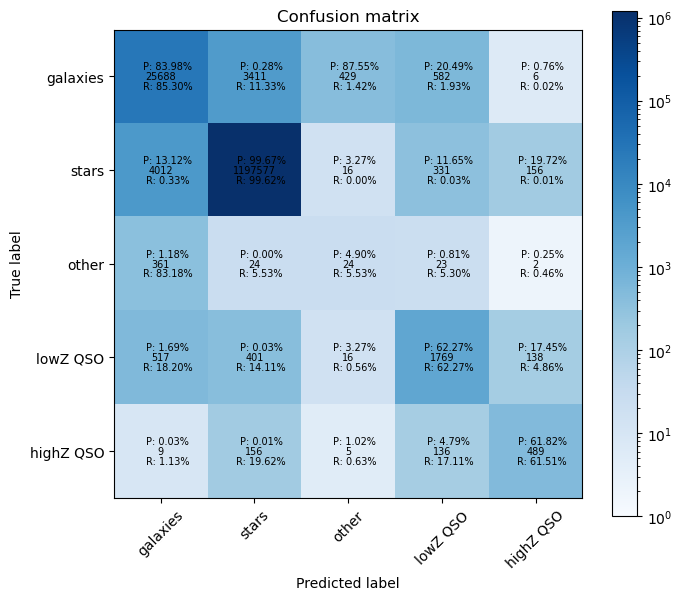

In [143]:
cm=metrics.confusion_matrix(ytest, ypred)
plot_confusion_matrix(cm,idlabels , normalize=False,fontsize=7)
plt.savefig("figures/skldtc_{}.png".format(name),dpi=300)

In [144]:



DT_basic_regressor = xgb.XGBClassifier()
DT_basic_regressor.fit(Xtrain, ytrain)
ypred = DT_basic_regressor.predict(Xtest)




Confusion matrix, without normalization
[[  26632    3283      14     184       3]
 [    342 1201638       1      89      22]
 [    400      17       6      11       0]
 [    509     368       1    1882      81]
 [      5     135       0      92     563]]


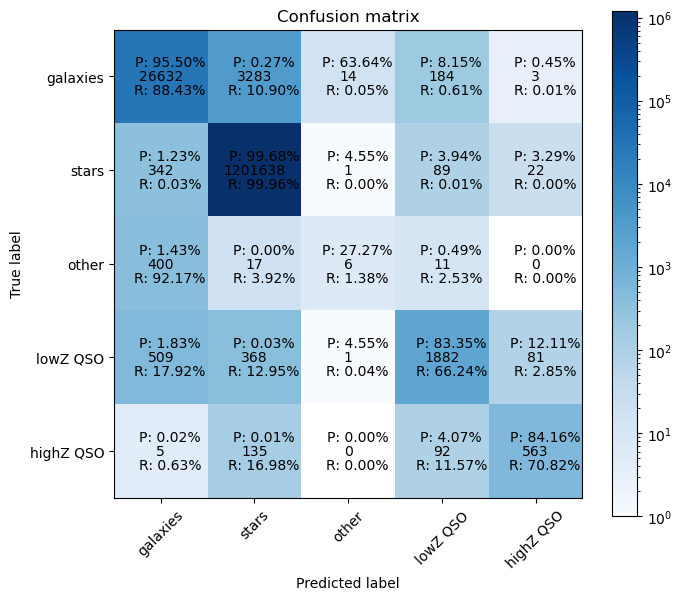

In [145]:
cm=metrics.confusion_matrix(ytest, ypred)
plot_confusion_matrix(cm,idlabels , normalize=False,fontsize=10)
plt.savefig("figures/xgbcsimple_{}.png".format(name),dpi=300)

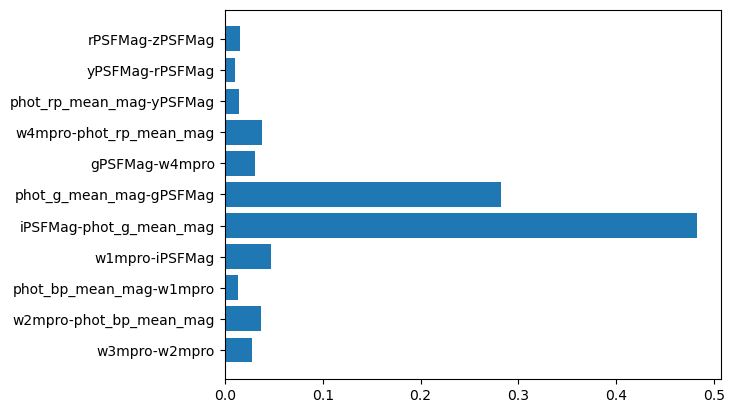

In [125]:
#plot the feature importances
#plt.figure(figsize=(15, 10))
plt.barh(features.columns, DT_basic_regressor.feature_importances_,orientation="horizontal")
plt.savefig("figures/influence_xgbsimple_{}.png".format(name),dpi=300)


In [ ]:
param = {
    'max_depth': 10,  
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(label2num_map) } 


steps = 10 



In [ ]:
#vprasanja 

#klasifikacija - kaj qso.
#ali bolje vec classov, da razdelimo tudi gal na lowz highz
#ali kaksna prednost v binarni klasifikaciji
#kaj z nan oziroma negativnimi vrednostmi?

#26.6.
#Velikost razredov pomaga. Bundlat zelo razlicne razrede ni zelo koristno, prav tako ni zelo koristno imeti mnogo
#manjsih razredov. Algoritem jih ne bo mogel razlociti. Preizkusi, kako to vpliva. Sicer priporocilo galaksije (plus extended),
#potem posebej QSO. V eno kategorijo pa emlines, bllac, type2. 

#najbolj vplivni razredi so w4mpro in tam v IR, Morda tudi IZ? Identifikacija vplivnih razredov zgoraj ocitno pocne nekaj 
#narobe. Preveri, kako se obnasa zadeva, ce res odstranimo najbolj vpliven razred. 
#zaradi nekega razloga vkljucevanje vseh magnitud poveca recall (precissiona niti ne toliko). 

#negativne vrednosti magnitude. Kdaj je bolj pametno, ce se jih da na NaN. Ce gre za klasifikacijo je najbrz ok ce samo
#uporabis zelo veliko vrednost. Ce gre za regresijo, je bolje, da jih das na NaN, nekateri algoritmi lahko to handlajo.

#normalizacija barv. Tu najbrz ne naredi mnogo razlike ker gre za podoben velikostni red. Vseeno lahko poizkusis kaj z ali brez.

#confusion matrix, uredi tako da kaze normalizacijo glede na recall ali precision.



In [ ]:
param = {
    'max_depth': 10,  
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(idlabels)
    }
steps = 100  

In [ ]:
#make a xgboost regressor 
DT_basic_regressor = xgb.XGBClassifier()

In [ ]:
watchlist = [(D_train, 'Train'), (D_test,'Test')]
evals_result = {}
model = xgb.train(param, D_train, steps, watchlist, evals_result=evals_result,early_stopping_rounds=10)
print(evals_result)
Nsteps

In [ ]:
watchlist = [(D_train, 'Train'), (D_test,'Test')]
evals_result = {}

In [59]:
#find best parameters
parameters = {'max_depth':[10,20,None], 'n_estimators':[50,100], 
              'learning_rate': [0.1, 0.3, 0.5], 'objective':['multi:softprob'],
              'eval_metric':['mlogloss'], 'num_class':[len(idlabels)]}


nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(xgb.XGBRegressor(), parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features, labels)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [57]:
print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Best params, best score: nan {'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'num_class': 5, 'objective': 'multi:softprob'}


In [146]:
parameters = {'base_estimator__max_depth':[6,10,None], 'loss':['linear','square'], 'n_estimators':[20,50,100], 'learning_rate': [0.3,0.5,1.0]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), parameters, \
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(ml_features,ml_targets.values.ravel())


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time= 1.6min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time= 1.6min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time= 1.6min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time= 1.6min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time= 1.6min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time= 3.5min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time= 3.5min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time= 3.5min
[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; tot

/Users/gregorrih/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV] END base_estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time= 3.5min


KeyboardInterrupt: 

In [97]:
ml_targets.describe()

,labels
count,1184734
unique,7
top,star
freq,1013809


In [98]:
print(df["objtype"].unique())

['Extended?' 'Galaxy' ' ' 'star' 'Type2' 'QSO' 'EmLines' 'BLLac'
 'Uncertain']
